In [2]:
#imports

import ast                     # try_literal_eval()
import numpy as np              
import pandas as pd             
from pathlib import Path        
import tensorflow_hub as hub    # loading Universal Sentence Encoder
from tensorflow.keras.callbacks import EarlyStopping   
from tensorflow.keras import layers, models, utils     # build_ffnn, one-hot, etc.
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold    # cross-validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler       # numeric feature scaling
import matplotlib.pyplot as plt  # class distribution plot
from sklearn.utils.class_weight import compute_class_weight  # class weights
import re                       # clean_text()




RANDOM_STATE = 42
N_JOBS = -1

pd.set_option("display.max_colwidth", 120)

/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
#reading in data

def read_semicolon_csv(path):
    return pd.read_csv(path, sep=';', dtype=str, keep_default_na=False)

DATA_DIR = Path('.')
train_path = DATA_DIR / 'train.csv'
test_path  = DATA_DIR / 'test-no-labels.csv'

train_df = read_semicolon_csv(train_path)
test_df  = read_semicolon_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:",  test_df.shape)
train_df.head(2)

print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

Train shape: (2999, 8)
Test shape: (823, 7)
Train columns: ['chef_id', 'recipe_name', 'data', 'tags', 'steps', 'description', 'ingredients', 'n_ingredients']
Test columns: ['recipe_name', 'data', 'tags', 'steps', 'description', 'ingredients', 'n_ingredients']


In [4]:
# helper: parse strings into lists
def try_literal_eval(x):
    if isinstance(x, list):
        return x
    try:
        val = ast.literal_eval(x)
        if isinstance(val, (list, tuple)):
            return [str(i) for i in val]
        return [str(val)]
    except Exception:
        # fallback: just split on commas
        return [t.strip() for t in str(x).split(',') if t.strip()]

# helper: strings to floats
def parse_numeric(x):
    try:
        return float(x)
    except Exception:
        return np.nan

# parsing list-like columns
for col in ['tags', 'steps', 'ingredients']:
    train_df[col] = train_df[col].apply(try_literal_eval)
    test_df[col]  = test_df[col].apply(try_literal_eval)

# make sure n_ingredients is numeric
train_df['n_ingredients_num'] = train_df['n_ingredients'].apply(parse_numeric)
test_df['n_ingredients_num']  = test_df['n_ingredients'].apply(parse_numeric)

# fill missing numeric values using ingredient list length
train_df['n_ingredients_num'] = np.where(train_df['n_ingredients_num'].isna(),
                                         train_df['ingredients'].apply(len),
                                         train_df['n_ingredients_num'])
test_df['n_ingredients_num'] = np.where(test_df['n_ingredients_num'].isna(),
                                        test_df['ingredients'].apply(len),
                                        test_df['n_ingredients_num'])

# ensure textual columns are strings
text_cols = ['recipe_name', 'data', 'description']
for c in text_cols:
    train_df[c] = train_df[c].astype(str)
    test_df[c]  = test_df[c].astype(str)

# get the target labels (the chef IDs)
y = train_df['chef_id'].astype(str).values
classes = np.unique(y)
print("Classes (chefs):", classes.tolist(), "->", len(classes), "classes")

Classes (chefs): ['1533', '3288', '4470', '5060', '6357', '8688'] -> 6 classes


In [5]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Example combined text:

name chefy s rice pudding. date 29012002. description by request, from georgian bay gourmet.. tags 60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, for-large-groups, desserts, lunch, rice, canadian, oven, easy, potluck, dinner-party, fall, heirloom-historical, holiday-event, kid-friendly, winter, puddings-and-mousses, grains, dietary, low-s

Numeric feature example (first 5 rows):
   n_ingredients_num_scaled  n_steps_scaled
0                 -0.833448       -0.234484
1                  1.065464        1.176185
2                  0.794191        0.647184
3                 -1.375995       -1.292486
4                  1.065464        3.821190


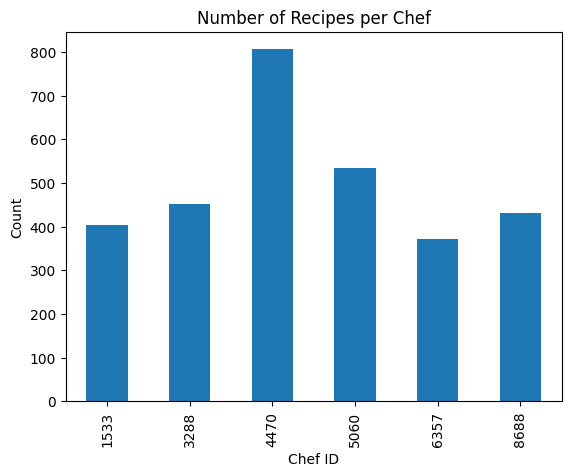

1533    404
3288    451
4470    806
5060    534
6357    372
8688    432
Name: count, dtype: int64

Proportions (%):
1533    13.47
3288    15.04
4470    26.88
5060    17.81
6357    12.40
8688    14.40
Name: count, dtype: float64
{0: np.float64(1.2372112211221122), 1: np.float64(1.108277900960828), 2: np.float64(0.6201406120760959), 3: np.float64(0.9360174781523096), 4: np.float64(1.3436379928315412), 5: np.float64(1.1570216049382716)}


In [6]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)     # collapse multiple spaces
    text = re.sub(r'[^\w\s,.!?-]', '', text)  # remove weird symbols
    text = text.strip().lower()
    return text

def combine_all_text(df):
    return (
        "name: " + df['recipe_name'].fillna('') + '. ' +
        "date: " + df['data'].fillna('') + '. ' +
        "description: " + df['description'].fillna('') + '. ' +
        "tags: " + df['tags'].apply(lambda lst: ', '.join(lst) if isinstance(lst, list) else str(lst)) + '. ' +
        "steps: " + df['steps'].apply(lambda lst: '. '.join(lst) if isinstance(lst, list) else str(lst)) + '. ' +
        "ingredients: " + df['ingredients'].apply(lambda lst: ', '.join(lst) if isinstance(lst, list) else str(lst)) + '.'
    ).apply(clean_text)

X_alltext = combine_all_text(train_df)

print("Example combined text:\n")
print(X_alltext.iloc[0][:400])

# count steps
train_df['n_steps'] = train_df['steps'].apply(len)
test_df['n_steps'] = test_df['steps'].apply(len)

scaler = StandardScaler()
numeric_train = scaler.fit_transform(train_df[['n_ingredients_num', 'n_steps']])
numeric_test  = scaler.transform(test_df[['n_ingredients_num', 'n_steps']])

print("\nNumeric feature example (first 5 rows):")
print(pd.DataFrame(numeric_train, columns=['n_ingredients_num_scaled', 'n_steps_scaled']).head())

# chef data balance chart
chef_counts = pd.Series(y).value_counts().sort_index()
chef_counts.plot(kind='bar')
plt.title("Number of Recipes per Chef")
plt.xlabel("Chef ID")
plt.ylabel("Count")
plt.show()

print(chef_counts)
print("\nProportions (%):")
print((chef_counts / len(y) * 100).round(2))

class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights_dict = dict(zip(range(len(classes)), class_weights))
print(class_weights_dict)

In [7]:
# --- No augmentation version ---

# We simply use the original data as-is
X_alltext_noaug = X_alltext
numeric_train_noaug = numeric_train
y_noaug = y

classes_noaug = np.unique(y_noaug)

print("\nUsing original (non-augmented) dataset:")
print("Samples:", len(X_alltext_noaug))
print("Classes:", len(classes_noaug))



Using original (non-augmented) dataset:
Samples: 2999
Classes: 6


In [11]:
classes_noaug = np.unique(y_noaug)

# model
def build_ffnn():
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(514,)),  # 512 + 2 numeric
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(classes_noaug), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# k-fold training
kf = StratifiedKFold(n_splits=12, shuffle=True, random_state=RANDOM_STATE)
fold_accuracies = []


for fold, (train_idx, val_idx) in enumerate(kf.split(X_alltext_noaug, y_noaug), 1):
    print(f"\n----- Fold {fold}/{kf.n_splits} -----")
    X_train_fold, X_val_fold = X_alltext_noaug.iloc[train_idx], X_alltext_noaug.iloc[val_idx]
    y_train_fold, y_val_fold = y_noaug[train_idx], y_noaug[val_idx]

    # embeddings
    X_train_embed = embed(X_train_fold.tolist())
    X_val_embed   = embed(X_val_fold.tolist())

    # Numeric features
    n_train = numeric_train_noaug[train_idx]
    n_val   = numeric_train_noaug[val_idx]

    # Combine text and numeric features
    X_train_concat = np.hstack([X_train_embed, n_train])
    X_val_concat   = np.hstack([X_val_embed, n_val])

    # One-hot encode labels
    y_train_cat = utils.to_categorical(pd.Categorical(y_train_fold, categories=classes_noaug).codes)
    y_val_cat   = utils.to_categorical(pd.Categorical(y_val_fold, categories=classes_noaug).codes)

    # Train
    model = build_ffnn()
    early_stop = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

    history = model.fit(
        X_train_concat, y_train_cat,
        validation_data=(X_val_concat, y_val_cat),
        epochs=30, batch_size=32, verbose=0,
        callbacks=[early_stop]
        # NOTE: we remove class_weights since we now balanced classes via augmentation
    )

    loss, acc = model.evaluate(X_val_concat, y_val_cat, verbose=0)
    print(f"Fold {fold} accuracy: {acc*100:.2f}%")
    fold_accuracies.append(acc)

print("\nCross-validation results:")
print(f"Mean accuracy: {np.mean(fold_accuracies)*100:.2f}% ± {np.std(fold_accuracies)*100:.2f}%")




----- Fold 1/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 accuracy: 71.60%

----- Fold 2/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 2 accuracy: 66.40%

----- Fold 3/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 3 accuracy: 68.00%

----- Fold 4/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 4 accuracy: 66.00%

----- Fold 5/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 5 accuracy: 67.60%

----- Fold 6/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 6 accuracy: 70.00%

----- Fold 7/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 7 accuracy: 73.60%

----- Fold 8/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 8 accuracy: 70.00%

----- Fold 9/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 9 accuracy: 70.80%

----- Fold 10/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 10 accuracy: 68.40%

----- Fold 11/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 11 accuracy: 65.60%

----- Fold 12/12 -----


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 12 accuracy: 71.89%

Cross-validation results:
Mean accuracy: 69.16% ± 2.45%



Evaluating model for confusion matrix...
Epoch 1/30


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3353 - loss: 1.8024 - val_accuracy: 0.4900 - val_loss: 1.6902
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5308 - loss: 1.2245 - val_accuracy: 0.5217 - val_loss: 1.5978
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6105 - loss: 1.0573 - val_accuracy: 0.5900 - val_loss: 1.4780
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6780 - loss: 0.9085 - val_accuracy: 0.6133 - val_loss: 1.2964
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6976 - loss: 0.8163 - val_accuracy: 0.6417 - val_loss: 1.1252
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7201 - loss: 0.7388 - val_accuracy: 0.6667 - val_loss: 0.9930
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7469 - loss: 0.6843 - val_accuracy: 0.6567 - val_loss: 0.9408
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7639 - loss: 0.6408 - val_accuracy: 0.6683 - val_loss: 0.8544
Epo

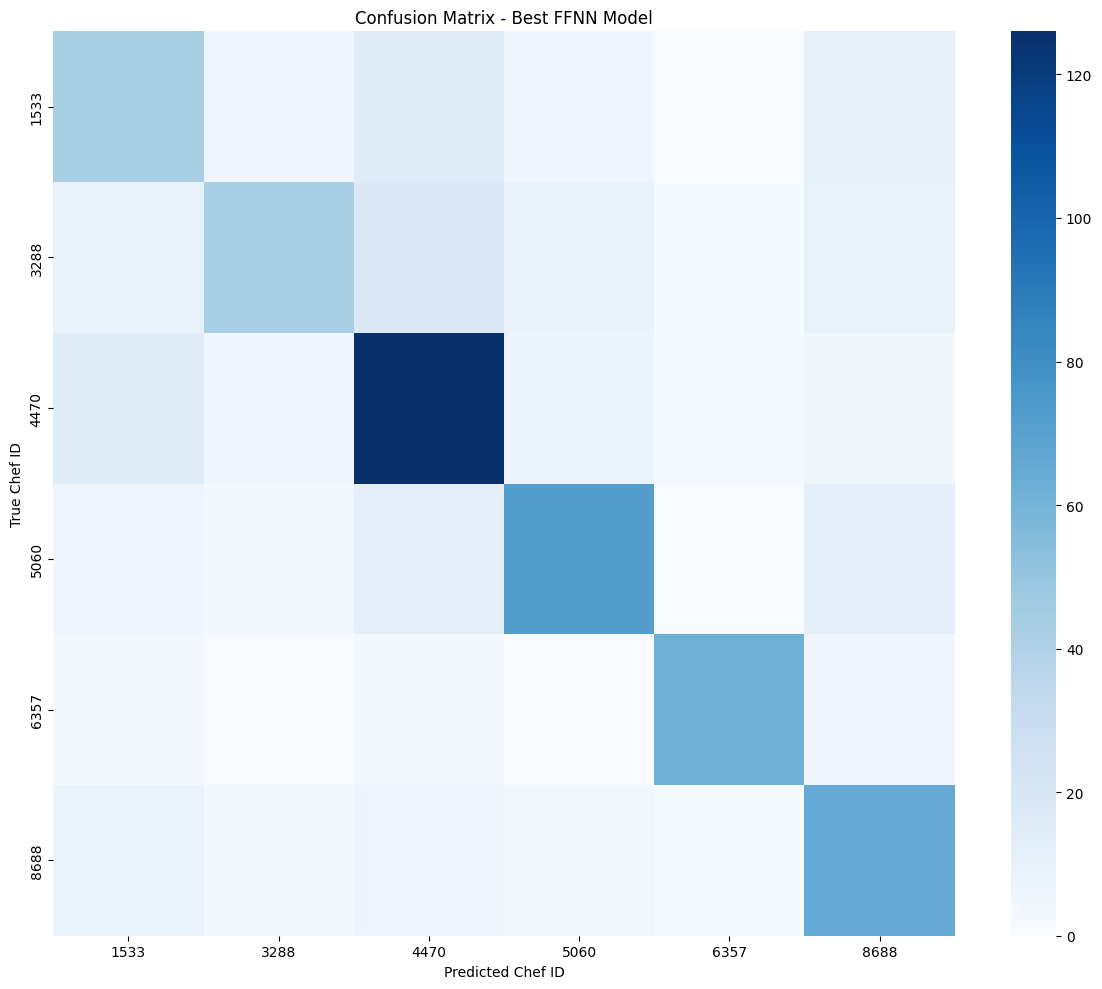

In [9]:
print("\nEvaluating model for confusion matrix...")

# use a single train/validation split
X_train_split, X_val_split, y_train_split, y_val_split, n_train_split, n_val_split = train_test_split(
    X_alltext_noaug, y_noaug, numeric_train_noaug, test_size=0.2, stratify=y_noaug, random_state=RANDOM_STATE
)

# Embed and concatenate features
X_train_embed = embed(X_train_split.tolist())
X_val_embed   = embed(X_val_split.tolist())
X_train_concat = np.hstack([X_train_embed, n_train_split])
X_val_concat   = np.hstack([X_val_embed, n_val_split])

# One-hot labels
y_train_cat = utils.to_categorical(pd.Categorical(y_train_split, categories=classes_noaug).codes)
y_val_cat   = utils.to_categorical(pd.Categorical(y_val_split, categories=classes_noaug).codes)

# Train a model for evaluation
model_eval = build_ffnn()
early_stop_eval = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_eval.fit(
    X_train_concat, y_train_cat,
    validation_data=(X_val_concat, y_val_cat),
    epochs=30, batch_size=32, verbose=1,
    callbacks=[early_stop_eval]
)

# Predictions on validation set
val_pred_probs = model_eval.predict(X_val_concat)
val_pred_indices = np.argmax(val_pred_probs, axis=1)
val_true_indices = pd.Categorical(y_val_split, categories=classes_noaug).codes


cm = confusion_matrix(val_true_indices, val_pred_indices)

tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (fp + fn + tp)

confusion_metrics = pd.DataFrame({
    'TP': tp,
    'FP': fp,
    'FN': fn,
    'TN': tn,
    'Precision': tp / (tp + fp + 1e-10),
    'Recall': tp / (tp + fn + 1e-10),
    'F1-Score': 2 * tp / (2 * tp + fp + fn + 1e-10),
    'Support': cm.sum(axis=1)
}, index=[str(c) for c in classes_noaug])

# sort by f1-score descending
confusion_metrics = confusion_metrics.sort_values(by='F1-Score', ascending=False)

print("\n=== Per-Chef Performance ===\n")
print(confusion_metrics.round(3))

# summarize overall averages
print("\n=== Summary (Macro Averages) ===")
print(confusion_metrics[['Precision', 'Recall', 'F1-Score']].mean().round(3))

# confusion matrix plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=classes_noaug, yticklabels=classes_noaug)
plt.title("Confusion Matrix - Best FFNN Model")
plt.xlabel("Predicted Chef ID")
plt.ylabel("True Chef ID")
plt.tight_layout()
plt.show()

In [10]:
# retraining full dataset for the test dataset
print("\nRetraining on full augmented dataset for final submission...")

X_full_embed = embed(X_alltext_noaug.tolist())
X_full_concat = np.hstack([X_full_embed, numeric_train_noaug])
y_full_cat = utils.to_categorical(pd.Categorical(y_noaug, categories=classes_noaug).codes)

final_model = build_ffnn()
early_stop_final = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

final_model.fit(X_full_concat, y_full_cat, epochs=30, batch_size=32, verbose=1, callbacks=[early_stop_final])

# test set predicting
X_test_all = combine_all_text(test_df)
X_test_embed = embed(X_test_all.tolist())
X_test_concat = np.hstack([X_test_embed, numeric_test])

pred_probs = final_model.predict(X_test_concat)
pred_indices = np.argmax(pred_probs, axis=1)
pred_labels = [classes_noaug[i] for i in pred_indices]

with open("results.txt", "w", encoding="utf-8") as f:
    f.write("\n")  # offset by 1 line for automatic testing
    f.write("\n".join(str(label) for label in pred_labels))


print("\nPredictions saved to results.txt")


Retraining on full augmented dataset for final submission...
Epoch 1/30


/Users/gargoyle/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3015 - loss: 1.8448
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5432 - loss: 1.1945
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6356 - loss: 0.9910
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6826 - loss: 0.8760
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7129 - loss: 0.7828
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7084 - loss: 0.7746
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7404 - loss: 0.7103
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 0.6373
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7708 - loss: 0.6355
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7849 - loss: 0.5599
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8171 - loss: 0.5088
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.5130
